In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection


In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 46kB/s 


## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, confusion_matrix, precision_recall_curve, \
average_precision_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier

In [0]:
# Custom Functions
import curves as C

In [0]:
dataset = pd.read_csv('creditcard.csv')
dataset_X = dataset.drop(['Class'], axis = 1)
dataset_y = dataset['Class']

## Splitting the dataset into the Training set and Test set

In [0]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)
    print('train-set size: ', len(y_train), 
          '\ntest-set size: ', len(y_test))    
    print('fraud cases in train-set', sum(y_train),
          '\nfraud cases in test-set: ', sum(y_test))
    return X_train, X_test, y_train, y_test

## Define function to get predictions

In [0]:
def get_predictions(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, cmap = "coolwarm", annot = True, linewidths = 0.5)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()
    print('==============================')
    print(cm)
    print('==============================')
    print('accuracy = {}'.format(accuracy_score(y_true, y_pred)))
    print('precision = {}'.format(precision_score(y_true, y_pred)))
    print('recall = {}'.format(recall_score(y_true, y_pred)))
    print('f1 score = {}'.format(f1_score(y_true, y_pred)))
    print('==============================')
    print(classification_report(y_true, y_pred))

## Feature importance plot

In [0]:
def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
    plt.figure(figsize = (15, 8))
    plt.title('Features importance', fontsize = 14)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation = 45)
    plt.show()

## Case 1: Drop 'Time', 'Amount'

In [0]:
drop_list = ['Time', 'Amount']
# drop_list = ['Time', 'Amount', 'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8']
X = dataset_X.drop(drop_list, axis = 1)
predictor_name = X.columns
X = X.values
y = dataset_y.values
print(predictor_name)
X_train, X_test, y_train, y_test = split_data(X, y)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
train-set size:  199364 
test-set size:  85443
fraud cases in train-set 344 
fraud cases in test-set:  148


 ## 1. CatBoostClassifier

### 1.1 CatBoostClassifier - Without hyperparameters tuning
EX: CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', learning_rate = 0.1)

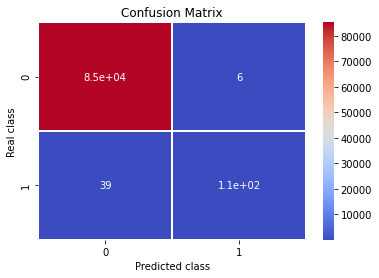

[[85289     6]
 [   39   109]]
accuracy = 0.9994733330992591
precision = 0.9478260869565217
recall = 0.7364864864864865
f1 score = 0.8288973384030419
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
# cb_clf = CatBoostClassifier(iterations = 200, learning_rate = 0.5, verbose = 0)
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1', 
                            learning_rate = 0.1, 
                            iterations = 100, 
                            verbose = 0, 
                            task_type = 'GPU')
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

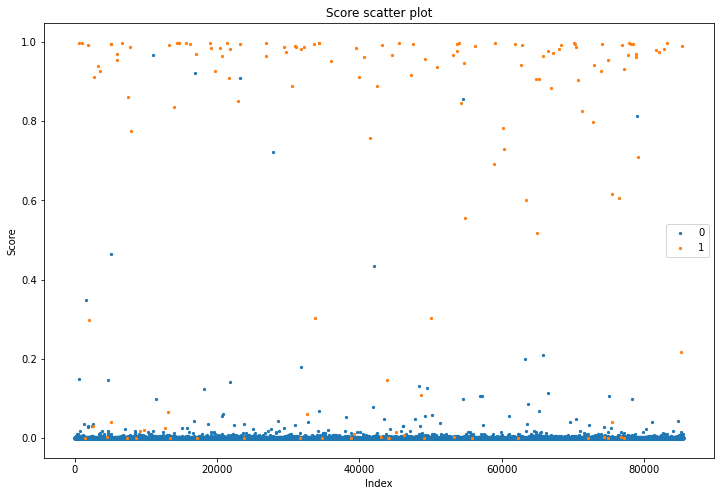

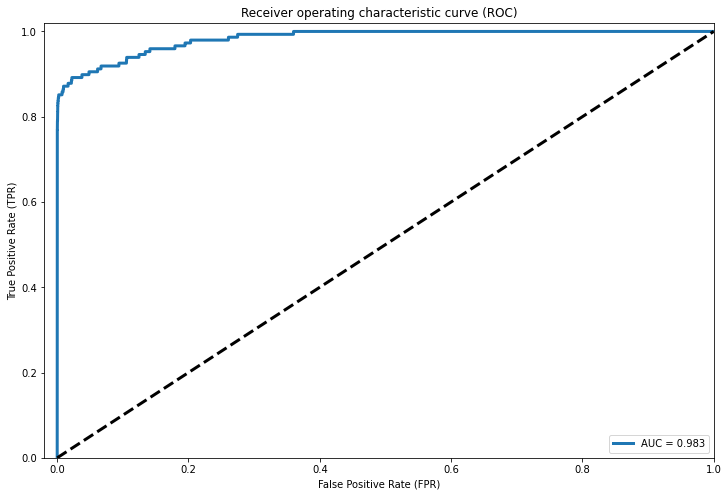

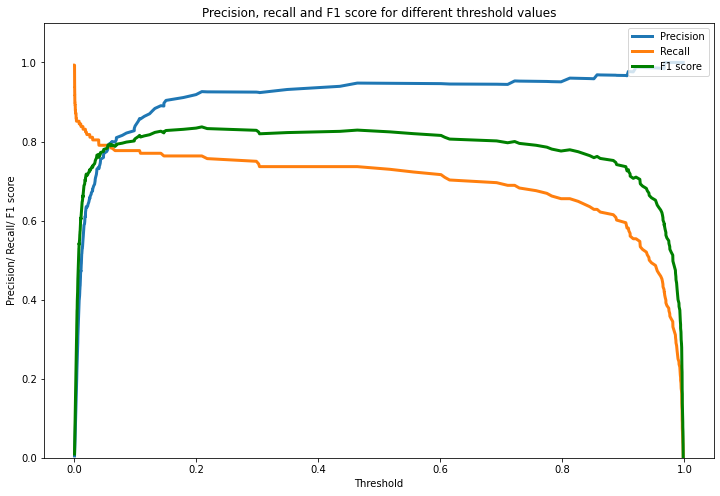

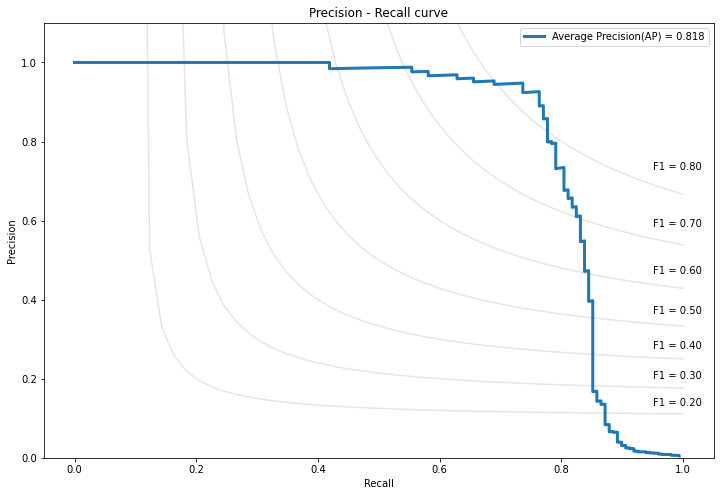

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_cb, tpr_cb, roc_auc_cb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_cb, recall_cb, threshold_cb, f1_scores_cb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_cb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

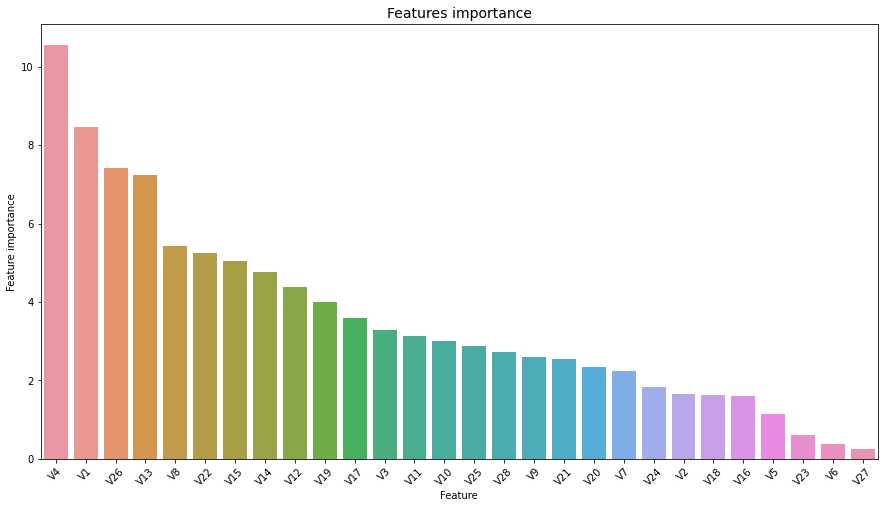

In [0]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)

### 1.2 Grid Search CV to optimize 'F1'

In [0]:
classifier = CatBoostClassifier(loss_function = 'Logloss', 
                                eval_metric = 'F1', 
                                task_type = 'GPU')
'''
parameter = {'learning_rate': [0.1, 0.5, 1], 
             'iterations': [100],
             'depth': [4],
             'l2_leaf_reg': [1]}
'''
parameter = {'learning_rate': np.arange(0.01, 1, 0.01), 
             'iterations': [50, 100, 200]}
skf = StratifiedKFold(n_splits = 5, random_state = 0)
randomized_search_result = classifier.randomized_search(parameter, 
                                                        X = X_train,
                                                        y = y_train, 
                                                        cv = skf,
                                                        plot = True)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8707483	best: 0.8707483 (0)	total: 3.93s	remaining: 35.4s
1:	loss: 0.8827586	best: 0.8827586 (1)	total: 7.88s	remaining: 31.5s
2:	loss: 0.9041096	best: 0.9041096 (2)	total: 11.7s	remaining: 27.4s
3:	loss: 0.8611111	best: 0.9041096 (2)	total: 15.8s	remaining: 23.7s
4:	loss: 0.8979592	best: 0.9041096 (2)	total: 22.8s	remaining: 22.8s
5:	loss: 0.8979592	best: 0.9041096 (2)	total: 29.7s	remaining: 19.8s
6:	loss: 0.8904110	best: 0.9041096 (2)	total: 36.8s	remaining: 15.8s
7:	loss: 0.8888889	best: 0.9041096 (2)	total: 43.8s	remaining: 10.9s
8:	loss: 0.9054054	best: 0.9054054 (8)	total: 56.7s	remaining: 6.3s
9:	loss: 0.8933333	best: 0.9054054 (8)	total: 1m 9s	remaining: 0us
Estimating final quality...


In [0]:
print(randomized_search_result['params'])

{'iterations': 200, 'learning_rate': 0.05}


### 1.3 CatBoost with best parameters

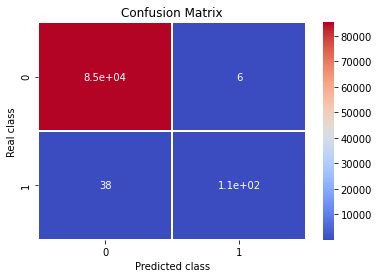

[[85289     6]
 [   38   110]]
accuracy = 0.9994850368081645
precision = 0.9482758620689655
recall = 0.7432432432432432
f1 score = 0.8333333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
cb_clf = CatBoostClassifier(loss_function = 'Logloss', 
                            eval_metric = 'F1',
                            learning_rate = 0.05, 
                            iterations = 200,
                            verbose = 0, 
                            task_type = 'GPU')
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

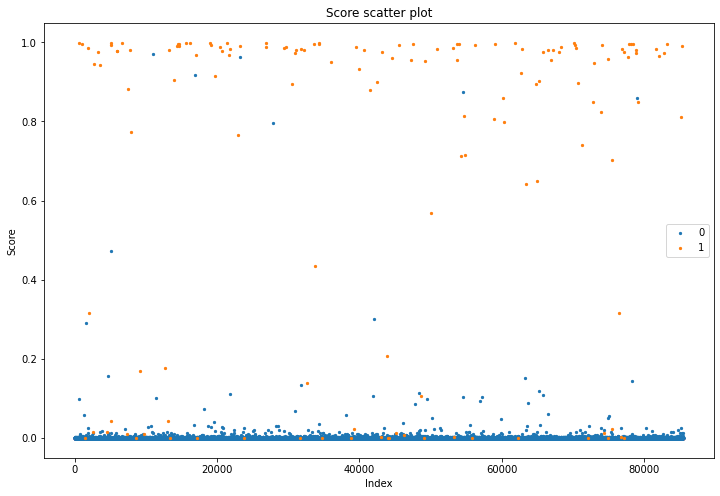

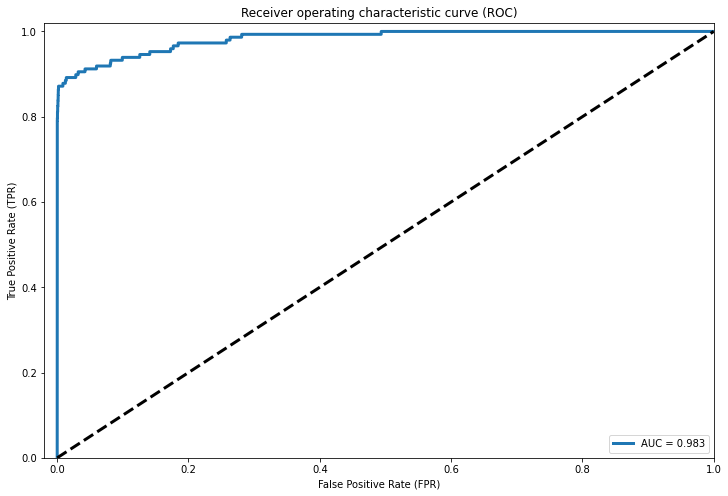

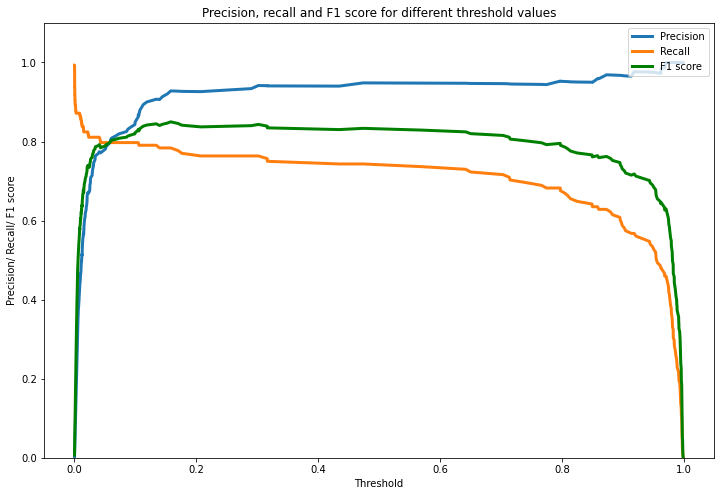

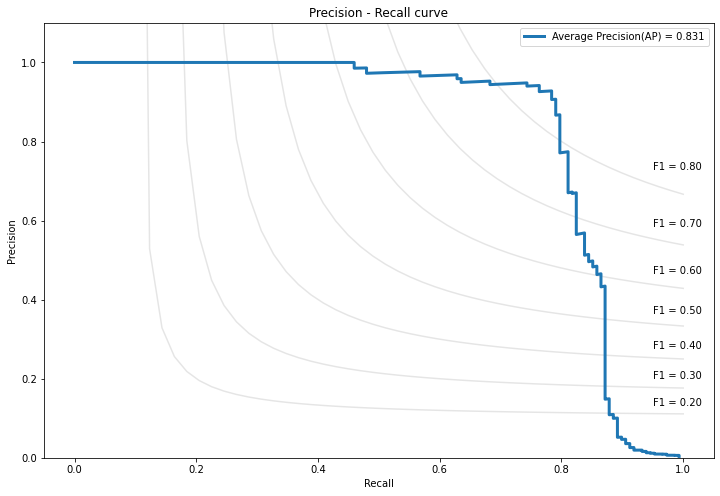

In [0]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_cb, tpr_cb, roc_auc_cb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_cb, recall_cb, threshold_cb, f1_scores_cb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_cb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

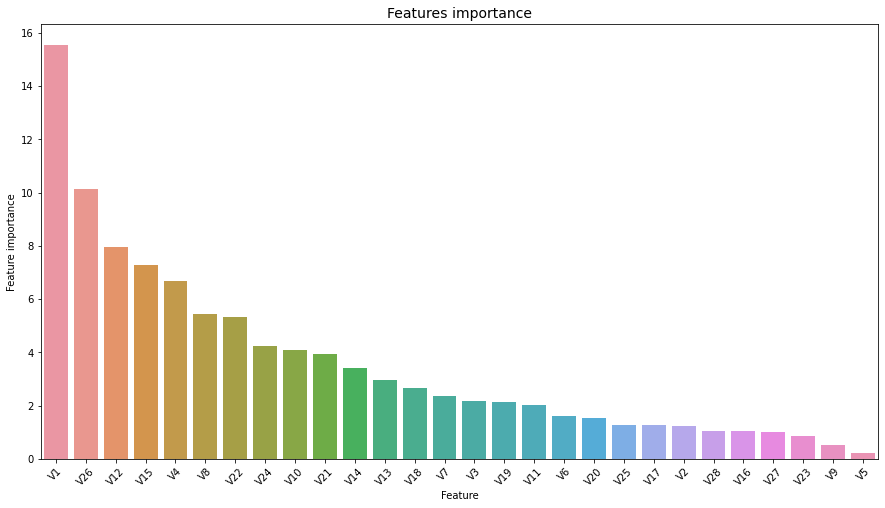

In [0]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)